<a href="https://www.kaggle.com/code/ssalijoshua/eda-code?scriptVersionId=221933195" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [37]:
import pandas as pd
import numpy as np
import scipy.io
import h5py
import mne
import matplotlib.pyplot as plt
import os

### Examining the structures inside the EEG_full

In [71]:
import h5py

# Define file paths
file_path_open = "/kaggle/input/arousal/S01_C_OLoop.mat"  # Open-loop data
file_path_closed = "/kaggle/input/arousal/S01_F_CL_Sil_50_100.mat"  # Closed-loop data

# Load open-loop data
mat_data_open = h5py.File(file_path_open, 'r')
mat_data_closed = h5py.File(file_path_closed, 'r')

# Check if 'actualVariable' exists in both files
if 'actualVariable' in mat_data_open and 'actualVariable' in mat_data_closed:
    actual_var_open = mat_data_open['actualVariable']
    actual_var_closed = mat_data_closed['actualVariable']
    
    print("Keys inside actualVariable (Open Loop):", list(actual_var_open.keys()))
    print("Keys inside actualVariable (Closed Loop):", list(actual_var_closed.keys()))
    
    # Check if 'EEG_full' exists
    if 'EEG_full' in actual_var_open and 'EEG_full' in actual_var_closed:
        eeg_full_open = actual_var_open['EEG_full']
        eeg_full_closed = actual_var_closed['EEG_full']
        
        print("Keys inside EEG_full (Open Loop):", list(eeg_full_open.keys()))
        print("Keys inside EEG_full (Closed Loop):", list(eeg_full_closed.keys()))
    else:
        print("'EEG_full' not found in one or both datasets.")
else:
    print("'actualVariable' not found in one or both datasets.")


Keys inside actualVariable (Open Loop): ['EEG_full']
Keys inside actualVariable (Closed Loop): ['EEG_full']
Keys inside EEG_full (Open Loop): ['chaninfo', 'chanlocs', 'comments', 'condition', 'data', 'dipfit', 'epoch', 'epochdescription', 'etc', 'event', 'eventdescription', 'filename', 'filepath', 'group', 'history', 'icaact', 'icachansind', 'icasphere', 'icasplinefile', 'icaweights', 'icawinv', 'nbchan', 'pnts', 'ref', 'reject', 'saved', 'session', 'setname', 'specdata', 'specicaact', 'splinefile', 'srate', 'stats', 'subject', 'times', 'trials', 'urchanlocs', 'urevent', 'xmax', 'xmin']
Keys inside EEG_full (Closed Loop): ['chaninfo', 'chanlocs', 'comments', 'condition', 'data', 'dipfit', 'epoch', 'epochdescription', 'etc', 'event', 'eventdescription', 'filename', 'filepath', 'group', 'history', 'icaact', 'icachansind', 'icasphere', 'icasplinefile', 'icaweights', 'icawinv', 'nbchan', 'pnts', 'ref', 'reject', 'saved', 'session', 'setname', 'specdata', 'specicaact', 'splinefile', 'srate'

### Examining the chaninfo

In [40]:
if 'chaninfo' in eeg_full:
    eeg_data = eeg_full['chaninfo']
    print("Keys inside chaninfo:", list(eeg_data.keys()))
else:
    print("'data' not found inside 'EEG_full'")


Keys inside chaninfo: ['filecontent', 'filename', 'icachansind', 'nodatchans', 'nosedir', 'plotrad', 'shrink']


### Examining chanlocs

In [41]:
if 'chanlocs' in eeg_full:
    eeg_data = eeg_full['chanlocs']
    print("Keys inside chanlocs:", list(eeg_data.keys()))
else:
    print("'data' not found inside 'EEG_full'")


Keys inside chanlocs: ['X', 'Y', 'Z', 'labels', 'radius', 'ref', 'sph_phi', 'sph_radius', 'sph_theta', 'theta', 'type', 'urchan']


### Combining the chanlocs

In [42]:
# Extract channel labels
channel_labels = []

chanlocs = eeg_full['chanlocs']

for ref in chanlocs['labels']:
    obj = mat_data[ref[0]]  # Dereference
    label = ''.join(map(chr, obj[:].flatten()))  # Convert to string
    channel_labels.append(label)

def extract_data(ref_array):
    """Extracts numeric data from HDF5 references, ensuring uniform shape."""
    values = []
    
    for ref in ref_array:
        obj = mat_data[ref[0]]  # Dereference
        
        data = obj[()]  # Extract value(s)
        if isinstance(data, np.ndarray):  
            data = data.flatten()  # Ensure it's 1D
            if data.size == 1:
                values.append(data[0])  # Append single value
            else:
                values.append(list(data))  # Append list if multiple values
        else:
            values.append(data)  # Append scalar directly
    
    return values  # Return list instead of NumPy array

# Convert fields into lists of numerical values
df_chanlocs = pd.DataFrame({
    "Channel": channel_labels,
    "X": extract_data(chanlocs['X']),
    "Y": extract_data(chanlocs['Y']),
    "Z": extract_data(chanlocs['Z']),
    "Theta": extract_data(chanlocs['theta']),
    "Sph_Phi": extract_data(chanlocs['sph_phi']),
    "Sph_Theta": extract_data(chanlocs['sph_theta']),
    "Sph_Radius": extract_data(chanlocs['sph_radius'])
})

# Display the cleaned DataFrame
df_chanlocs

,Channel,X,Y,Z,Theta,Sph_Phi,Sph_Theta,Sph_Radius
0,Fp1,0.950477,0.308829,-0.034899,-18.0,-2.0,18.0,1.0
1,AF7,0.787531,0.615286,-0.034899,-38.0,-2.0,38.0,1.0
2,AF3,0.884846,0.375595,0.275637,-23.0,16.0,23.0,1.0
3,F1,0.710264,0.286965,0.642788,-22.0,40.0,22.0,1.0
4,F3,0.673028,0.545007,0.5,-39.0,30.0,39.0,1.0
...,...,...,...,...,...,...,...,...
139,Flight-time,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
140,Course-type,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
141,FB-type,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
142,Ring-type,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"


### Electrode placement

In [43]:
# Keep only rows where X, Y, Z are numbers (filter out metadata)
df_cleaned = df_chanlocs[df_chanlocs["X"].apply(lambda x: isinstance(x, float))]

df_cleaned


,Channel,X,Y,Z,Theta,Sph_Phi,Sph_Theta,Sph_Radius
0,Fp1,0.950477,0.308829,-0.034899,-18.0,-2.0,18.0,1.0
1,AF7,0.787531,0.615286,-0.034899,-38.0,-2.0,38.0,1.0
2,AF3,0.884846,0.375595,0.275637,-23.0,16.0,23.0,1.0
3,F1,0.710264,0.286965,0.642788,-22.0,40.0,22.0,1.0
4,F3,0.673028,0.545007,0.5,-39.0,30.0,39.0,1.0
...,...,...,...,...,...,...,...,...
59,P8,-0.587427,-0.808524,-0.034899,126.0,-2.0,-126.0,1.0
60,P10,-0.532714,-0.733218,-0.422618,126.0,-25.0,-126.0,1.0
61,PO8,-0.808524,-0.587427,-0.034899,144.0,-2.0,-144.0,1.0
62,PO4,-0.884846,-0.375595,0.275637,157.0,16.0,-157.0,1.0


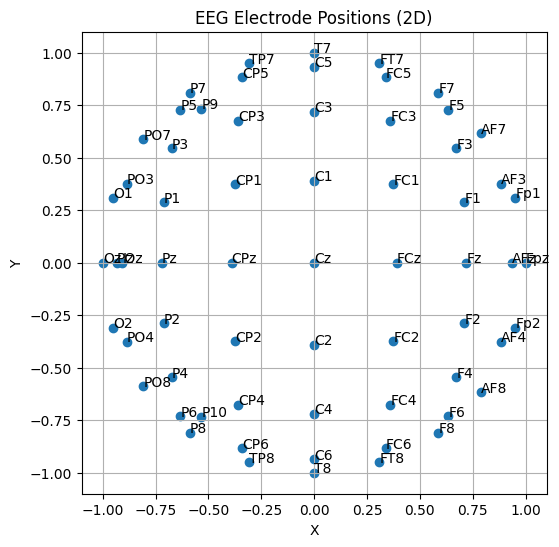

In [44]:
# Plot the electrode positions
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df_cleaned['X'], df_cleaned['Y'], label='Electrodes')

# Annotate each electrode with its channel label
for i, label in enumerate(df_cleaned['Channel']):
    ax.annotate(label, (df_cleaned['X'][i], df_cleaned['Y'][i]))

# Add labels, title, and grid
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('EEG Electrode Positions (2D)')
plt.grid(True)

# Save the figure before displaying it
plt.savefig("2D_electrode_placement.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()

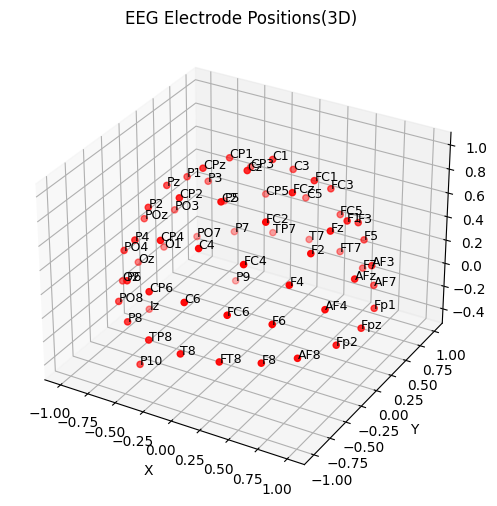

In [45]:
# Visualizing electrode placement

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Extract valid coordinates
x, y, z = df_cleaned["X"], df_cleaned["Y"], df_cleaned["Z"]

# Scatter plot
ax.scatter(x, y, z, c='r', marker='o')

# Label the points
for i, channel in enumerate(df_cleaned["Channel"]):
    ax.text(x.iloc[i], y.iloc[i], z.iloc[i], channel, fontsize=9)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("EEG Electrode Positions(3D)")
plt.savefig("3D_electrode_placement.png") 
plt.show()


### Checking the labels

In [46]:
# labels = extract_data(eeg_full['chanlocs']['labels'])
# pd.DataFrame(labels)

### Obtaining the data

In [47]:
if 'data' in eeg_full:
    eeg_data = eeg_full['data']
    eeg_data = pd.DataFrame(eeg_data)
    eeg_data

### Converting the data to a pandas dataframe

In [48]:

# Assign column names
eeg_data.columns = channel_labels

# Display the first few rows
eeg_data

,Fp1,AF7,AF3,F1,F3,F5,F7,FT7,FC5,FC3,...,Head-raw-z,Head-x,Head-y,Head-z,Condition,Flight-time,Course-type,FB-type,Ring-type,LSL-time
0,-9.667615,-10.393621,-9.753345,-9.108747,-8.974578,-5.925375,-7.861744,-1.698606,-3.943043,-8.844296,...,0.956769,360.608093,356.855194,360.956757,6.2,62466.0,1.0,2.0,1.000000,21898.416016
1,-6.141129,-6.836845,-4.873523,-4.312459,-3.933507,-3.081656,-3.486265,1.742102,-0.792778,-3.365051,...,0.956769,360.608093,356.855194,360.956757,6.2,62466.0,1.0,2.0,1.000000,21898.419922
2,-4.675134,-4.363692,-0.448084,0.772359,0.550915,0.214158,-2.643757,-0.211528,1.913509,2.298281,...,0.957018,360.609161,356.857086,360.956879,6.2,62466.0,1.0,2.0,1.000000,21898.423828
3,-6.067291,-3.423522,-0.172872,1.712570,1.301004,1.842866,-5.526480,-4.801501,1.971172,3.726157,...,0.957268,360.611298,356.860901,360.957153,6.2,62466.0,1.0,2.0,1.000000,21898.427734
4,-9.710501,-6.376214,-4.447028,-1.877157,-2.537558,-1.611499,-7.792553,-6.148304,-1.637977,-0.723085,...,0.957517,360.613464,356.864685,360.957397,6.2,62466.0,1.0,2.0,1.000000,21898.431641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441416,-16.771263,-1.611429,-9.319777,-9.373400,-6.722995,-5.973288,-12.990420,3.213263,-2.209813,-7.078461,...,1.951199,366.123444,359.607849,361.954285,6.5,62060.0,2.0,2.0,14.399902,25092.478516
441417,-19.246191,-4.546033,-9.070182,-9.906972,-7.394595,-7.195506,-13.011345,2.857405,-3.107048,-6.887184,...,1.945038,366.097504,359.598328,361.948120,6.5,62060.0,2.0,2.0,14.399902,25092.482422
441418,-19.239399,-9.205249,-12.321740,-12.276237,-10.223580,-9.013595,-7.696752,3.142329,-3.342923,-6.567175,...,1.938877,366.071564,359.588776,361.941956,6.5,62060.0,2.0,2.0,14.399902,25092.486328
441419,-18.326254,-13.053471,-16.411980,-14.846927,-12.995174,-9.925069,-3.790742,3.904310,-3.906003,-7.464587,...,1.005654,362.919220,358.921997,361.472260,6.5,62060.0,2.0,2.0,1.000000,25092.490234


In [49]:
eeg_data.iloc[:,-1:]

,LSL-time
0,21898.416016
1,21898.419922
2,21898.423828
3,21898.427734
4,21898.431641
...,...
441416,25092.478516
441417,25092.482422
441418,25092.486328
441419,25092.490234


{'subject06': 1525.104, 'subject02': 997.104, 'subject10': 870.636, 'subject12': 1512.284, 'subject04': 1322.324, 'subject16': 879.252, 'subject01': 1765.684, 'subject19': 1378.18, 'subject17': 1111.044, 'subject15': 1091.14, 'subject05': 1367.616, 'subject07': 1297.92, 'subject09': 1372.572, 'subject03': 1282.612, 'subject08': 1307.864, 'subject18': 1147.916, 'subject20': 1447.48, 'subject11': 1391.324}


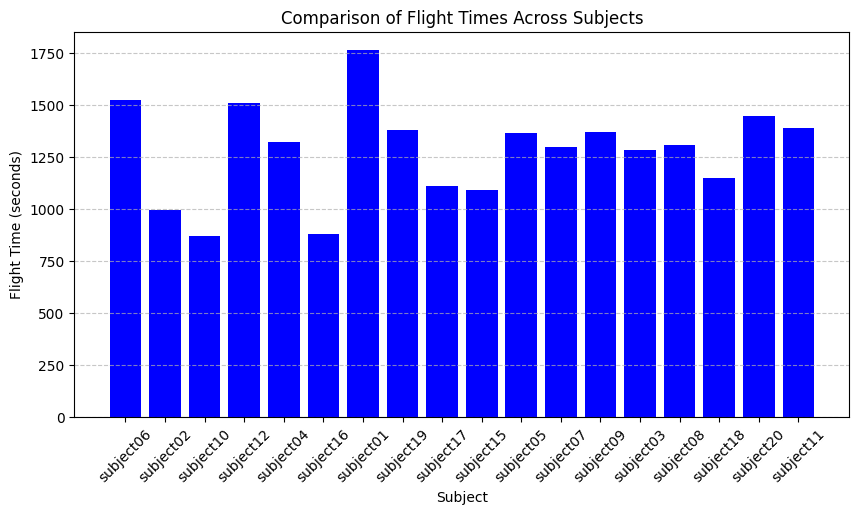

In [50]:
# Folder where your .mat files are stored
folder_path = "/kaggle/input/arousal/"

# Dictionary to store flight times with subject labels
flight_times = {}

# Get all .mat files
mat_files = [f for f in os.listdir(folder_path) if f.endswith('F_CL_Sil_50_100.mat')]

# Process each subject's file
for file in mat_files:
    # Extract the subject label from the file name (S01, S02, ...)
    subject_label = f"subject{int(file[1:3]):02d}"  # Example: 'S01' becomes 'subject1'

    file_path = os.path.join(folder_path, file)
    
    # Open the .mat file using h5py
    with h5py.File(file_path, 'r') as mat_file:
        # Navigate to the data field
        actual_variable = list(mat_file.keys())[0]  # Get the actual variable name dynamically
        eeg_full = mat_file[f"actualVariable/EEG_full/data"]  # Access the data field
        
        # Get the number of data points
        num_data_points = eeg_full.shape[0]  # Assuming data is stored as (channels, time)
        
        # Compute flight time (assuming 250 Hz sampling rate)
        flight_time = num_data_points / 250
        
        # Store the flight time in the dictionary
        flight_times[subject_label] = flight_time

# Print the dictionary of flight times
print(flight_times)

# Plot the flight times
plt.figure(figsize=(10, 5))
plt.bar(flight_times.keys(), flight_times.values(), color='b')
plt.xlabel("Subject")
plt.ylabel("Flight Time (seconds)")
plt.title("Comparison of Flight Times Across Subjects")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("Flight_times.png")
# Show the plot
plt.show()


### Analyzing frequency bands

In [51]:
# Check for NaN or infinite values
print("Missing values:", np.isnan(eeg_data).sum())
print("Infinite values:", np.isinf(eeg_data).sum())


Missing values: Fp1            0
AF7            0
AF3            0
F1             0
F3             0
              ..
Flight-time    0
Course-type    0
FB-type        0
Ring-type      0
LSL-time       0
Length: 144, dtype: int64
Infinite values: Fp1            0
AF7            0
AF3            0
F1             0
F3             0
              ..
Flight-time    0
Course-type    0
FB-type        0
Ring-type      0
LSL-time       0
Length: 144, dtype: int64


### Sampling rate

In [52]:

sampling_rate = mat_data['actualVariable']['EEG_full']['srate'][()]
print("Sampling Rate:", sampling_rate)


Sampling Rate: [[256.]]


### One EEG channel over time

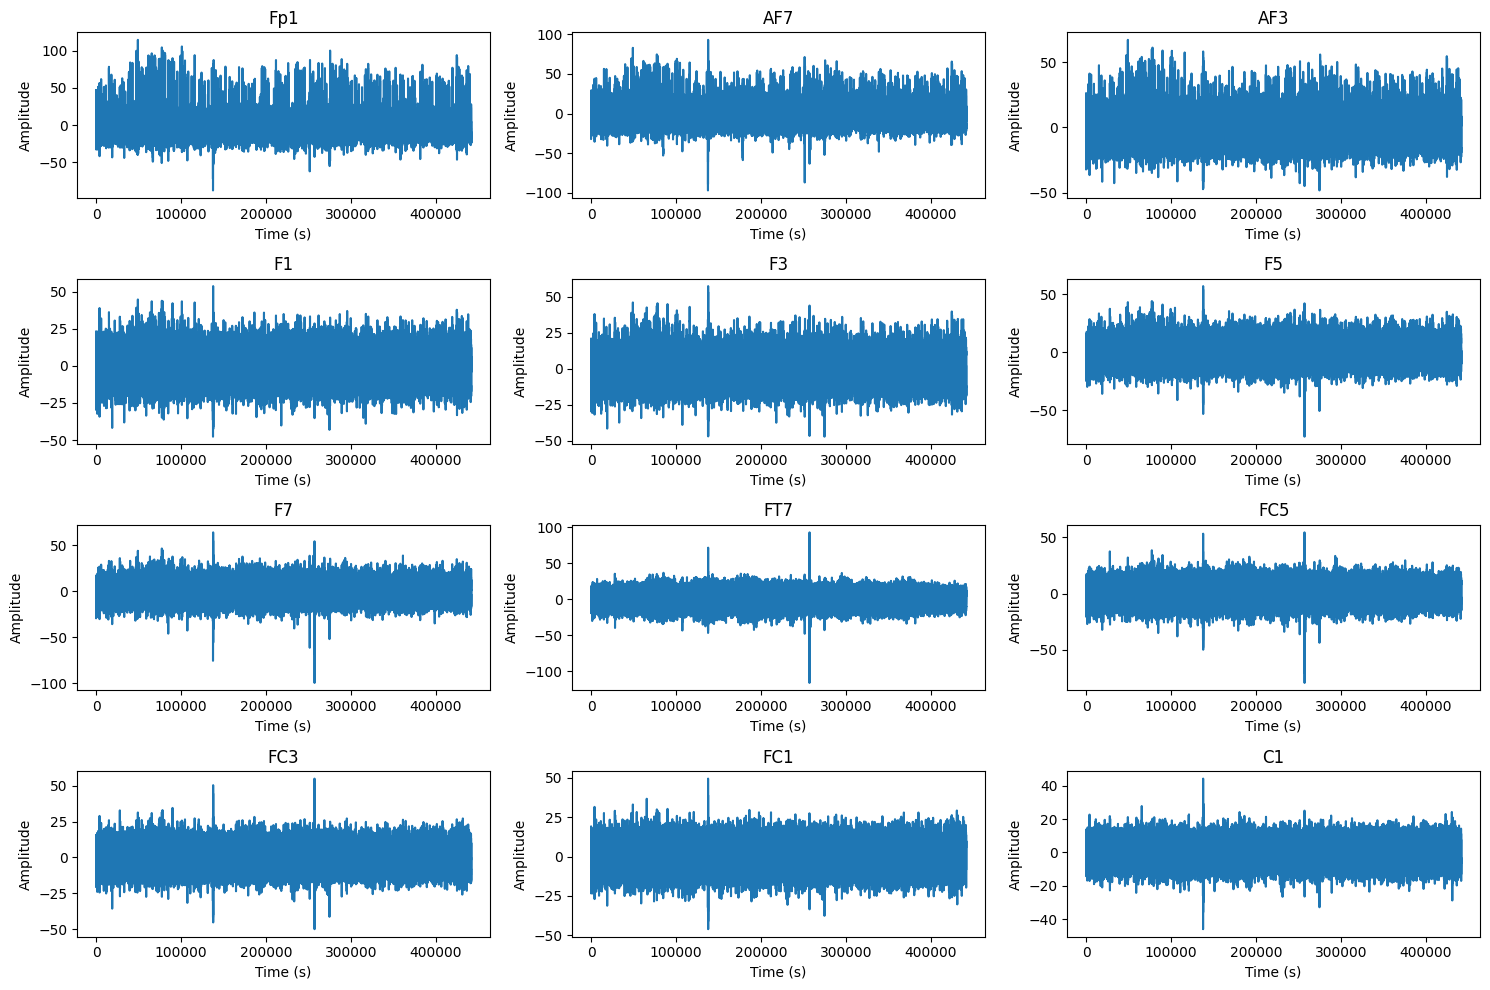

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example: Let's assume eeg_data is a pandas DataFrame
# eeg_data = pd.DataFrame(np.random.randn(441421, 12), columns=['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1'])

# Select first 12 channels using iloc
selected_channels = eeg_data.iloc[:, :12]

# Create time axis based on the number of rows in the data
time = np.arange(selected_channels.shape[0])  # Adjust to the number of rows in eeg_data

# Plot the selected channels
plt.figure(figsize=(15, 10))

channels = selected_channels.columns

for i, channel in enumerate(channels):
    plt.subplot(4, 3, i + 1)  # Create a 4x3 grid of subplots
    plt.plot(time, selected_channels[channel])  # Plot each channel's data
    plt.title(channel)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

plt.tight_layout()  # Adjust spacing between subplots
plt.savefig("channels_v_time.png")
plt.show()


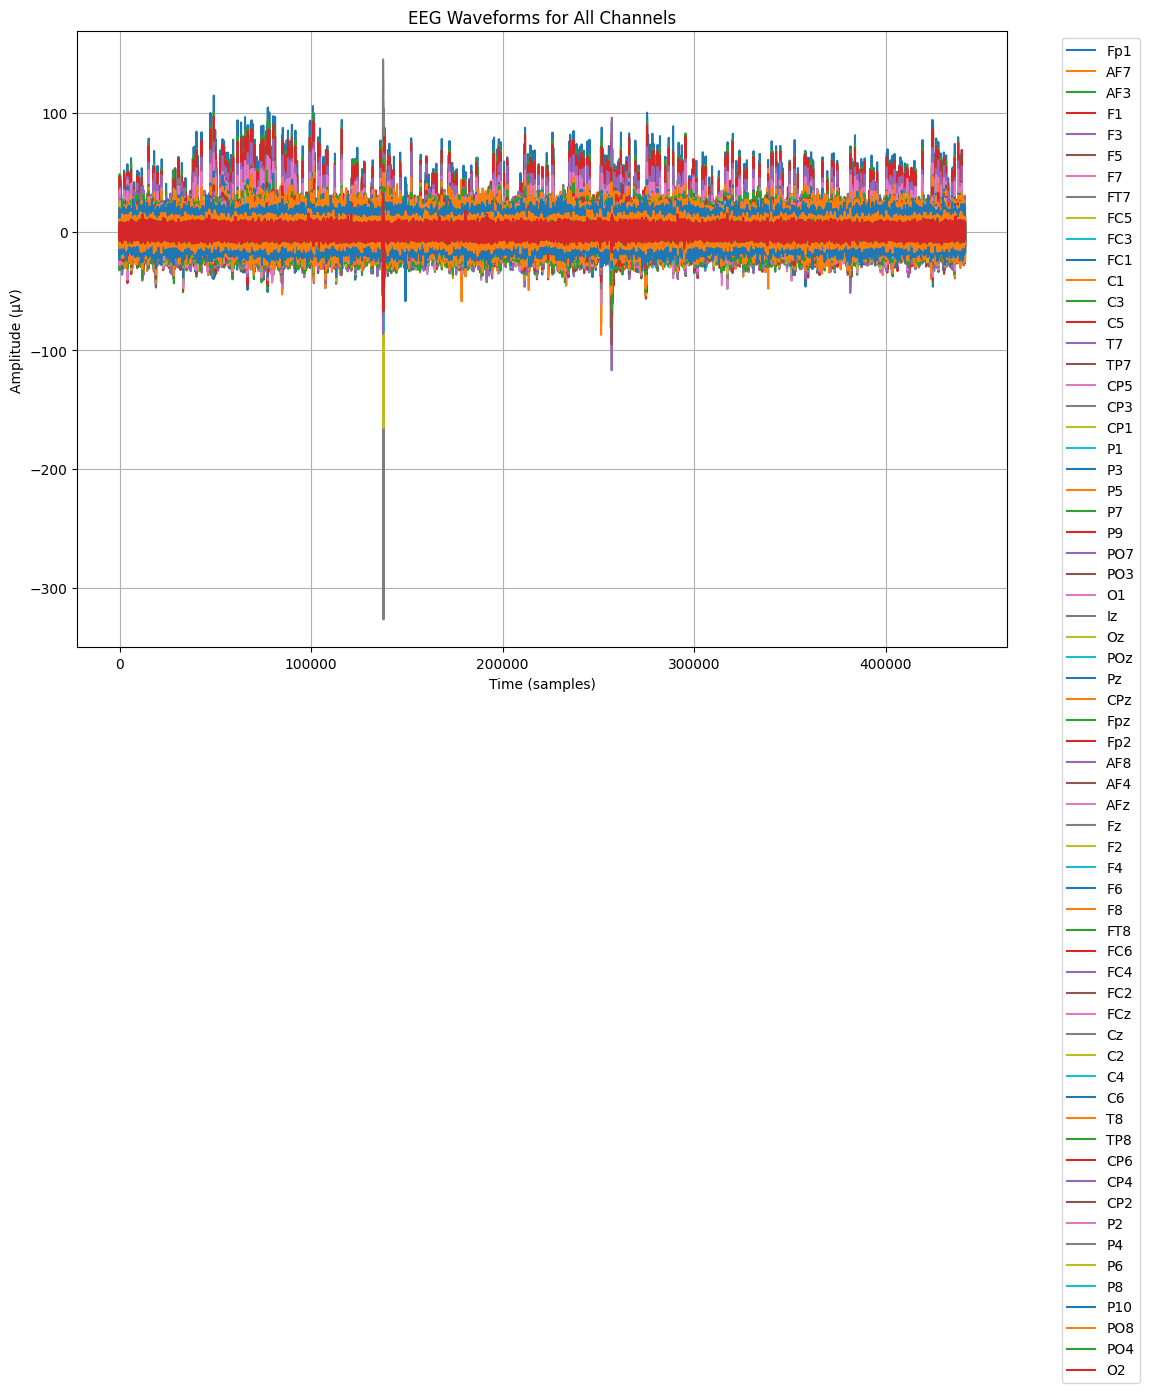

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_cleaned is your DataFrame with EEG data
# List of EEG channel names
channels = df_cleaned['Channel'].tolist()

# Select only the EEG channels and the time column (if applicable)
time_column = eeg_data.index  # Assuming the index is the time or you could use a specific column if you have a 'time' column.
eeg_data = eeg_data[channels]

# Plot all EEG waveforms on the same graph
plt.figure(figsize=(12, 8))

for channel in channels:
    plt.plot(time_column, eeg_data[channel], label=channel)

# Add labels and title
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (µV)')
plt.title('EEG Waveforms for All Channels')
plt.grid(True)

# Add a legend to differentiate the channels
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.savefig("waveforms_4_channels.png")
plt.show()

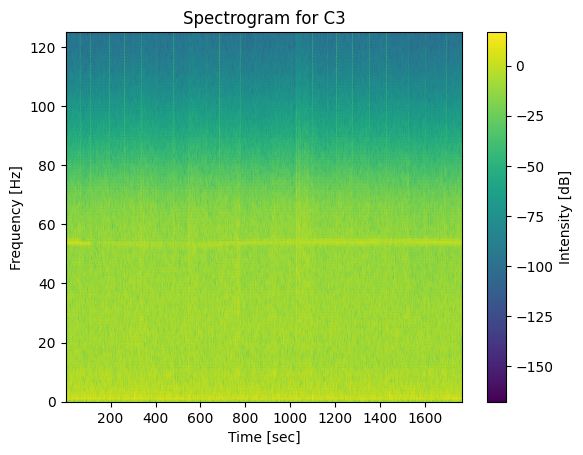

In [55]:
from scipy import signal
import matplotlib.pyplot as plt

# Example for a single channel
fs = 250  # Sampling frequency3'
f, t, Sxx = signal.spectrogram(eeg_data['C3'], fs)
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram for C3')
plt.colorbar(label='Intensity [dB]')
plt.show()

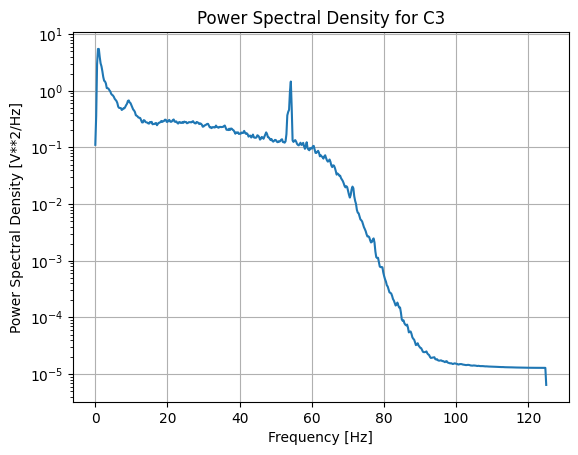

In [56]:
from scipy import signal
import matplotlib.pyplot as plt

# Example for a single channel
f, Pxx = signal.welch(eeg_data['C3'], fs=250, nperseg=1024)
plt.semilogy(f, Pxx)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density [V**2/Hz]')
plt.title('Power Spectral Density for C3')
plt.grid(True)
plt.savefig("Power_spectral_Density.png")
plt.show()

In [57]:
# import mne
# import numpy as np

# # Example data
# data = np.random.randn(64)  # Example data for 32 channels
# info = mne.create_info(ch_names=channels, sfreq=250, ch_types='eeg')
# evoked = mne.EvokedArray(data[:, np.newaxis], info)

# # Plot topographic map
# evoked.plot_topomap(times=[0], size=3, show=True)

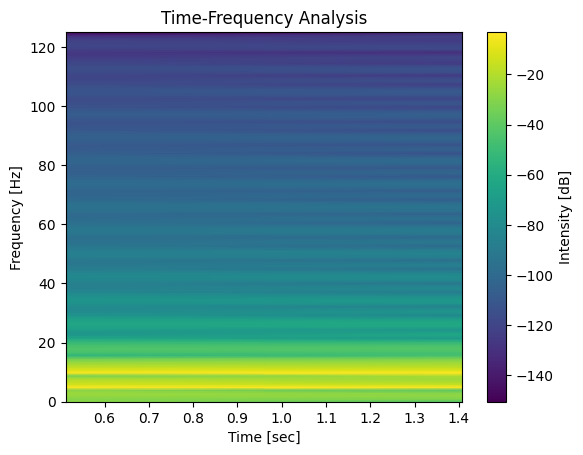

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Example for a single channel
t = np.linspace(0, 1, 500, endpoint=False)
sig = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 20 * t)
frequencies, times, Sxx = signal.spectrogram(sig, fs=250)

plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Time-Frequency Analysis')
plt.colorbar(label='Intensity [dB]')
plt.savefig("Time_frequency.png")
plt.show()

In [59]:
# import matplotlib.pyplot as plt

# # Example: Averaging across trials for a specific channel
# erp = eeg_data.groupby('event').mean()['C3']
# plt.plot(erp)
# plt.xlabel('Time (samples)')
# plt.ylabel('Amplitude (µV)')
# plt.title('Event-Related Potential for C3')
# plt.grid(True)
# plt.show()

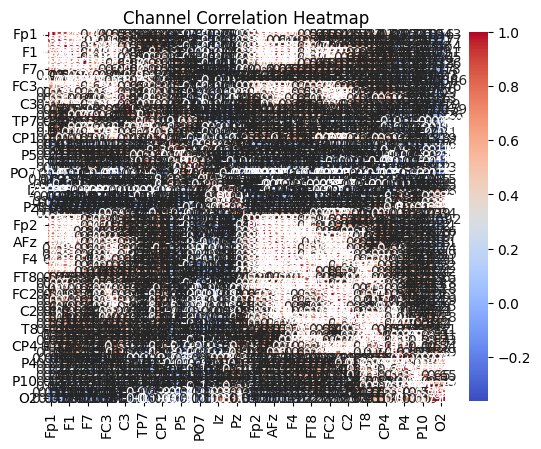

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = eeg_data.corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Channel Correlation Heatmap')
plt.savefig("corr.png")
plt.show()

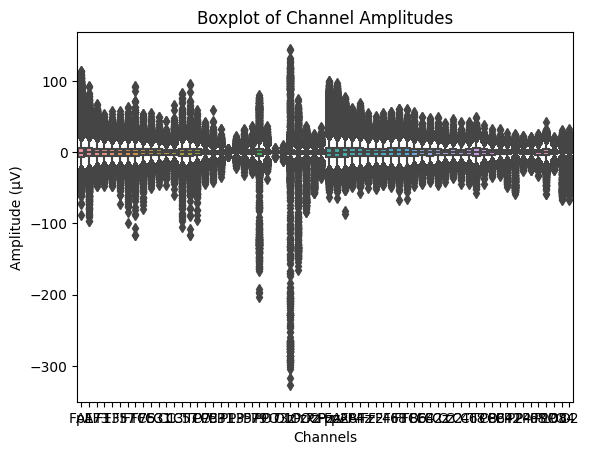

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot boxplot
sns.boxplot(data=eeg_data)
plt.xlabel('Channels')
plt.ylabel('Amplitude (µV)')
plt.title('Boxplot of Channel Amplitudes')
plt.show()

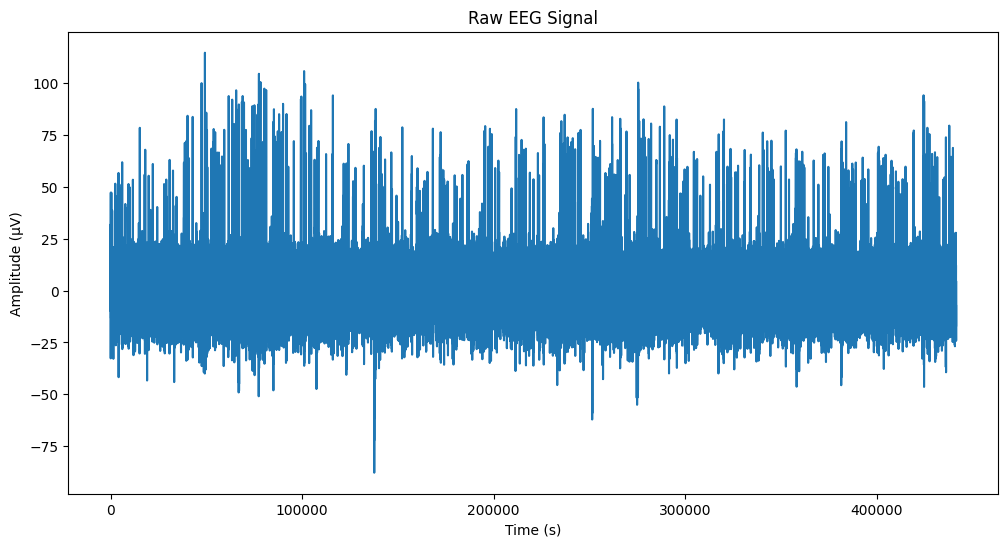

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(time, eeg_data.iloc[:, 0])  # Plot first channel
plt.title("Raw EEG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (μV)")
plt.savefig("raw_eeg_signal.png", dpi=300, bbox_inches='tight')
plt.show()


<ipython-input-63-077495f0a590>:8: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("eeg_moving_average.png", dpi=300, bbox_inches='tight')
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


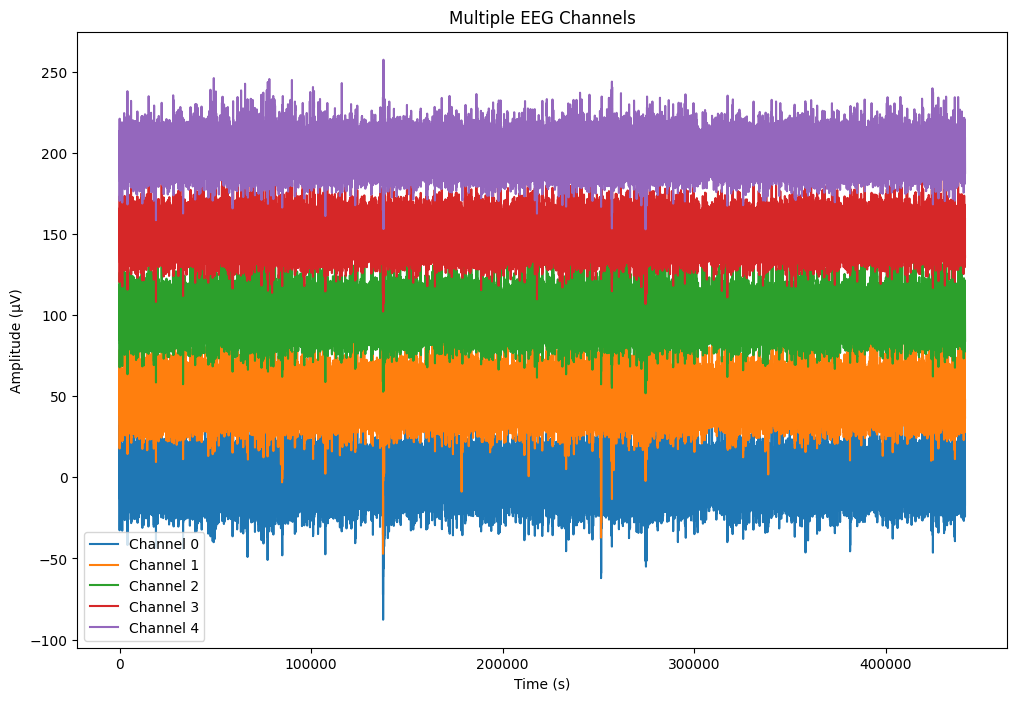

In [63]:
plt.figure(figsize=(12, 8))
for i in range(5):  # First 5 channels
    plt.plot(time, eeg_data.iloc[:, i] + i * 50, label=f'Channel {i}')
plt.legend()
plt.title("Multiple EEG Channels")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (μV)")
plt.savefig("eeg_moving_average.png", dpi=300, bbox_inches='tight')
plt.show()

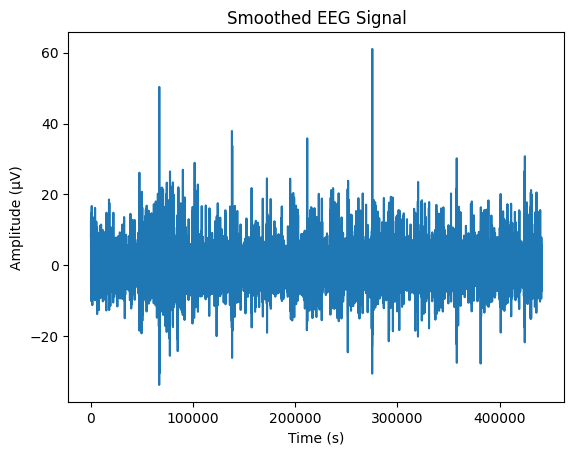

In [64]:
window_size = 100
smoothed_signal = eeg_data.iloc[:, 0].rolling(window=window_size).mean()
plt.plot(time, smoothed_signal)
plt.title("Smoothed EEG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (μV)")
plt.savefig("eeg_moving_average.png", dpi=300, bbox_inches='tight')
plt.show()


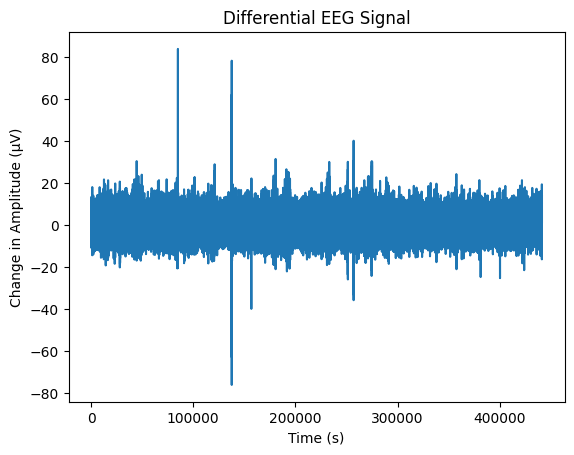

In [65]:
diff_signal = np.diff(eeg_data.iloc[:, 0])
plt.plot(time[:-1], diff_signal)
plt.title("Differential EEG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Change in Amplitude (μV)")
plt.savefig("smoothed_eeg_signal.png")
plt.show()


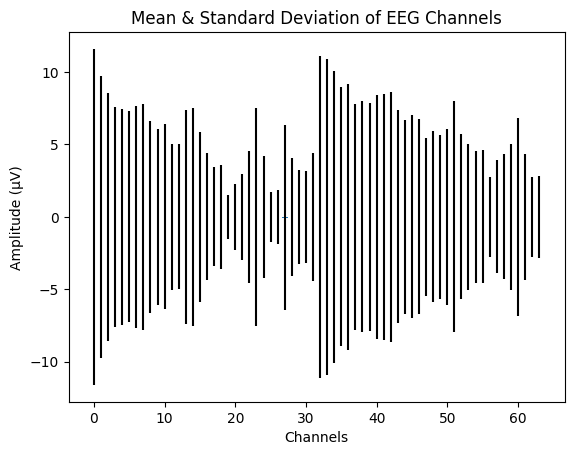

In [66]:
mean_values = eeg_data.mean()
std_values = eeg_data.std()
plt.bar(range(len(mean_values)), mean_values, yerr=std_values)
plt.title("Mean & Standard Deviation of EEG Channels")
plt.xlabel("Channels")
plt.ylabel("Amplitude (μV)")
plt.savefig("mean_and_SD.png", dpi=300, bbox_inches='tight')
plt.show()


In [67]:
!pip install antropy
import antropy as ant
samp_entropy = ant.sample_entropy(eeg_data.iloc[:, 0])
print("Sample Entropy:", samp_entropy)


Sample Entropy: 0.9501197021518455


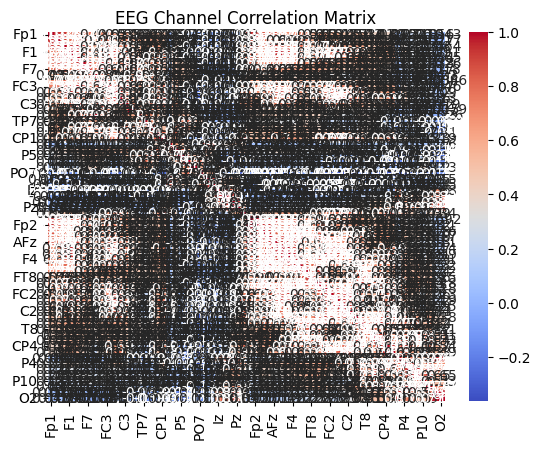

In [68]:
import seaborn as sns
corr_matrix = eeg_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("EEG Channel Correlation Matrix")
plt.savefig("eeg_correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()


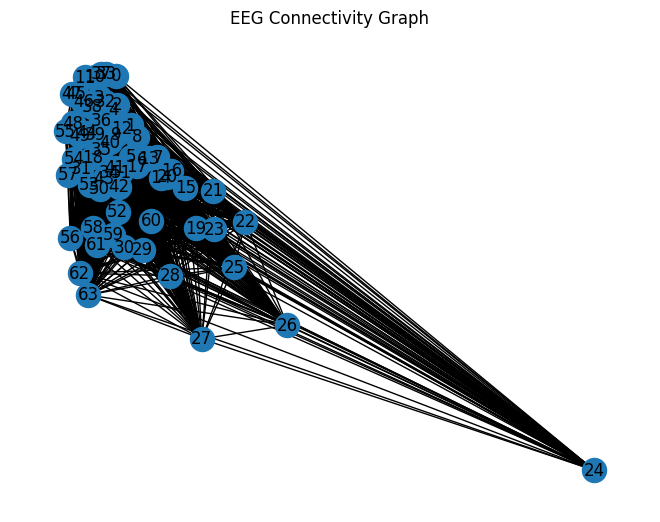

In [69]:
import networkx as nx
G = nx.Graph()
for i in range(len(eeg_data.columns)):
    for j in range(i + 1, len(eeg_data.columns)):
        G.add_edge(i, j, weight=np.corrcoef(eeg_data.iloc[:, i], eeg_data.iloc[:, j])[0, 1])
nx.draw(G, with_labels=True)
plt.title("EEG Connectivity Graph")
plt.savefig("eeg_graph.png", dpi=300, bbox_inches='tight')
plt.show()
